# Problem: Bike rental forecast

### Approach
- 1. Feature engineer the variables to be fit for the model 
- 2. Split train and test data set for validation 
- 3. Train a LinReg model 
- 3.1 Calculate test score and cross validate
- 4. Train and test Random Forest model
- 4.1 Calculate test score and cross validate
- 5. Optimize Hyperparameters

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
#from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from statsmodels.regression.linear_model import OLS
from scipy.stats import probplot
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

%matplotlib inline

In [6]:
# read in training set
bike = pd.read_csv('/Users/sabrinafruhauf/Desktop/05_SpicedCourse/Week_03_regression/bike-sharing-demand/train.csv', parse_dates=True)
# read in kaggle test set
bike_test = pd.read_csv('/Users/sabrinafruhauf/Desktop/05_SpicedCourse/Week_03_regression/bike-sharing-demand/test.csv', parse_dates=True)
bike_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


# 1. Feature engineering

In [7]:
bike_test.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

In [8]:
bike.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [9]:
bike["date"] = bike.datetime.apply(lambda x : x.split()[0])
bike["year_num"] = bike.date.apply(lambda x : x.split('-')[0]).astype('int')
bike["month_num"] = bike.date.apply(lambda x : x.split('-')[1]).astype('int')
bike["day_num"] = bike.date.apply(lambda x : x.split('-')[2]).astype('int')
bike["month"] = bike.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
bike["weekday"] = bike.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
bike["hour"] = bike.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype('int')
bike['atemp_shift'] = abs(bike['atemp'] -35)
bike['hour_8h'] = abs(bike['hour'] -8)
bike['hour_18h'] = abs(bike['hour'] -18)


bike_test["date"] = bike_test.datetime.apply(lambda x : x.split()[0])
bike_test["year_num"] = bike_test.date.apply(lambda x : x.split('-')[0]).astype('int')
bike_test["month_num"] = bike_test.date.apply(lambda x : x.split('-')[1]).astype('int')
bike_test["day_num"] = bike_test.date.apply(lambda x : x.split('-')[2]).astype('int')
bike_test["month"] = bike_test.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
bike_test["weekday"] = bike_test.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
bike_test["hour"] = bike_test.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype('int')
bike_test['atemp_shift'] = abs(bike_test['atemp'] -35)
bike_test['hour_8h'] = abs(bike_test['hour'] -8)
bike_test['hour_18h'] = abs(bike_test['hour'] -18)

In [10]:
#onehot encoding columns month and weekday
onehot_year = pd.get_dummies(bike['year_num'],prefix='year_')
onehot_month = pd.get_dummies(bike['month'])
onehot_weekday = pd.get_dummies(bike['weekday'])
onehot_hour = pd.get_dummies(bike['hour'],prefix='hour_')

bike = pd.concat([bike, onehot_year,onehot_month, onehot_weekday, onehot_hour], axis=1)

#test onehot encoding columns month and weekday
onehot_year_test = pd.get_dummies(bike_test['year_num'],prefix='year_')
onehot_month_test = pd.get_dummies(bike_test['month'])
onehot_weekday_test = pd.get_dummies(bike_test['weekday'])
onehot_hour_test = pd.get_dummies(bike_test['hour'],prefix='hour_')

bike_test = pd.concat([bike_test, onehot_year_test,onehot_month_test, onehot_weekday_test, onehot_hour_test], axis=1)

In [11]:
# min/max scale temp and atemp
# training set
scaler = MinMaxScaler() # scales each column to a min of 0 and a max of 1.0

temp_x = bike['temp'].values.reshape(-1,1)
scaler.fit(temp_x)  # <-- scaler records the minimum and maximum

atemp_x = bike['atemp'].values.reshape(-1,1)
scaler.fit(atemp_x)

bike['temp_scaled'] = scaler.transform(temp_x)
bike['atemp_scaled'] = scaler.transform(atemp_x)

#test set
temp_x_test = bike_test['temp'].values.reshape(-1,1)
scaler.fit(temp_x_test)  # <-- scaler records the minimum and maximum

atemp_x_test = bike_test['atemp'].values.reshape(-1,1)
scaler.fit(atemp_x_test)

bike_test['temp_scaled'] = scaler.transform(temp_x_test)
bike_test['atemp_scaled'] = scaler.transform(atemp_x_test)
#bike.head()

In [12]:
# add column for intercept (used in stats model later)
bike['intercept'] = 1
bike_test['intercept'] = 1

In [13]:
bike.columns, bike_test.columns

(Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
        'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
        'date', 'year_num', 'month_num', 'day_num', 'month', 'weekday', 'hour',
        'atemp_shift', 'hour_8h', 'hour_18h', 'year__2011', 'year__2012',
        'April', 'August', 'December', 'February', 'January', 'July', 'June',
        'March', 'May', 'November', 'October', 'September', 'Friday', 'Monday',
        'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'hour__0',
        'hour__1', 'hour__2', 'hour__3', 'hour__4', 'hour__5', 'hour__6',
        'hour__7', 'hour__8', 'hour__9', 'hour__10', 'hour__11', 'hour__12',
        'hour__13', 'hour__14', 'hour__15', 'hour__16', 'hour__17', 'hour__18',
        'hour__19', 'hour__20', 'hour__21', 'hour__22', 'hour__23',
        'temp_scaled', 'atemp_scaled', 'intercept'],
       dtype='object'),
 Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
        'ate

In [14]:
# reorder columns
bike = bike[['count','datetime','date', 'year_num', 'month_num', 'day_num', 'month', 'weekday', 'hour', 'season', 
             'holiday', 'workingday', 'weather', 'temp','temp_scaled','atemp', 'atemp_scaled','atemp_shift', 'humidity', 
             'windspeed', 'casual', 'registered',
             'year__2011', 'year__2012',
             'January','February','March','April', 'May', 'June', 'July', 'August', 'September', 'October',
             'November', 'December',
             'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'hour_8h', 'hour_18h',
             'hour__0', 'hour__1', 'hour__2', 'hour__3', 'hour__4','hour__5', 'hour__6', 'hour__7', 
             'hour__8', 'hour__9', 'hour__10','hour__11', 'hour__12', 'hour__13', 'hour__14', 'hour__15', 
             'hour__16','hour__17', 'hour__18', 'hour__19', 'hour__20', 'hour__21', 'hour__22','hour__23',
             'intercept']]
bike.head()

,count,datetime,date,year_num,month_num,day_num,month,weekday,hour,season,...,hour__15,hour__16,hour__17,hour__18,hour__19,hour__20,hour__21,hour__22,hour__23,intercept
0,16,2011-01-01 00:00:00,2011-01-01,2011,1,1,January,Saturday,0,1,...,0,0,0,0,0,0,0,0,0,1
1,40,2011-01-01 01:00:00,2011-01-01,2011,1,1,January,Saturday,1,1,...,0,0,0,0,0,0,0,0,0,1
2,32,2011-01-01 02:00:00,2011-01-01,2011,1,1,January,Saturday,2,1,...,0,0,0,0,0,0,0,0,0,1
3,13,2011-01-01 03:00:00,2011-01-01,2011,1,1,January,Saturday,3,1,...,0,0,0,0,0,0,0,0,0,1
4,1,2011-01-01 04:00:00,2011-01-01,2011,1,1,January,Saturday,4,1,...,0,0,0,0,0,0,0,0,0,1


## 2. Split train and test data set for validation 


In [15]:
x = bike[['datetime','date','year_num','year__2011','year__2012', 'month_num', 'day_num', 'month', 'weekday', 'hour', 
          'season', 'holiday', 'workingday', 'weather', 'temp','temp_scaled','atemp', 'atemp_scaled','atemp_shift', 'humidity', 
             'windspeed', 'casual', 'registered',
             'January','February','March','April', 'May', 'June', 'July', 'August', 'September', 'October',
             'November', 'December',
             'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday','hour_8h', 'hour_18h',
             'hour__0', 'hour__1', 'hour__2', 'hour__3', 'hour__4','hour__5', 'hour__6', 'hour__7', 
             'hour__8', 'hour__9', 'hour__10','hour__11', 'hour__12', 'hour__13', 'hour__14', 'hour__15', 
             'hour__16','hour__17', 'hour__18', 'hour__19', 'hour__20', 'hour__21', 'hour__22','hour__23',
             'intercept']]
y = bike['count']
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.2, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((8708, 69), (2178, 69), (8708,), (2178,))

In [16]:
# concatenate to a data frame again
df_train = pd.concat([ytrain, xtrain], axis=1)
df_test = pd.concat([ytest, xtest], axis=1)

# define log y for running the model
y_train = np.log1p(df_train['count'])

df_train.shape, df_test.shape

((8708, 70), (2178, 70))

## 3. Train a LinReg model 

## 3.1 Initialise function and test features in the model

In [65]:
# initialising model for feature testing
# categorizing features into different list 
x_basic = ['hour', 'atemp','year_num','month_num']
x_basic_scaled = ['hour', 'atemp_shift','year_num','month_num']
x_basic_plus = ['hour', 'atemp','year_num','month_num','season','weather','holiday','workingday', 'humidity','windspeed']
x_basic_plus_scaled = ['hour', 'atemp_shift','year_num','month_num','season','weather','holiday','workingday', 'humidity','windspeed']
x_detail = ['year__2011', 'year__2012','January','February', 'March', 'April', 'May', 'June', 
                     'July', 'August','September', 'October', 'November', 'December','Monday', 'Tuesday',
                     'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday','hour__0',
                     'hour__1', 'hour__2', 'hour__3', 'hour__4', 'hour__5', 'hour__6',
                     'hour__7', 'hour__8', 'hour__9', 'hour__10', 'hour__11', 'hour__12',
                     'hour__13', 'hour__14', 'hour__15', 'hour__16', 'hour__17', 'hour__18',
                     'hour__19', 'hour__20', 'hour__21', 'hour__22', 'hour__23','atemp']
x_detail_scaled = ['year__2011', 'year__2012','January','February', 'March', 'April', 'May', 'June', 
                     'July', 'August','September', 'October', 'November', 'December','Monday', 'Tuesday',
                     'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday','hour__0',
                     'hour__1', 'hour__2', 'hour__3', 'hour__4', 'hour__5', 'hour__6',
                     'hour__7', 'hour__8', 'hour__9', 'hour__10', 'hour__11', 'hour__12',
                     'hour__13', 'hour__14', 'hour__15', 'hour__16', 'hour__17', 'hour__18',
                     'hour__19', 'hour__20', 'hour__21', 'hour__22', 'hour__23','atemp_shift']
x_detail_plus = ['year__2011', 'year__2012','January','February', 'March', 'April', 'May', 'June', 
                     'July', 'August','September', 'October', 'November', 'December','Monday', 'Tuesday',
                     'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'hour__0',
                     'hour__1', 'hour__2', 'hour__3', 'hour__4', 'hour__5', 'hour__6',
                     'hour__7', 'hour__8', 'hour__9', 'hour__10', 'hour__11', 'hour__12',
                     'hour__13', 'hour__14', 'hour__15', 'hour__16', 'hour__17', 'hour__18',
                     'hour__19', 'hour__20', 'hour__21', 'hour__22', 'hour__23','temp','season','weather','holiday','workingday', 'humidity','windspeed']
x_detail_plus_scaled = ['year__2011', 'year__2012','January','February', 'March', 'April', 'May', 'June', 
                     'July', 'August','September', 'October', 'November', 'December','Monday', 'Tuesday',
                     'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday','hour_8h', 'hour_18h', 'hour__0',
                     'hour__1', 'hour__2', 'hour__3', 'hour__4', 'hour__5', 'hour__6',
                     'hour__7', 'hour__8', 'hour__9', 'hour__10', 'hour__11', 'hour__12',
                     'hour__13', 'hour__14', 'hour__15', 'hour__16', 'hour__17', 'hour__18',
                     'hour__19', 'hour__20', 'hour__21', 'hour__22', 'hour__23','atemp_shift','season','weather','holiday','workingday', 'humidity','windspeed']
#grouping lists into models 
xindex=[x_basic, x_basic_scaled, x_basic_plus, x_basic_plus_scaled, x_detail, x_detail_scaled,x_detail_plus,x_detail_plus_scaled]
mod_name=['model 1', 'model 2', 'model 3', 'model 4', 'model 5', 'model 6','model 7','model 8']


In [66]:
# define a function for training the 8 models defined
# calculate model scores mse, rmse, mae, r2, msle, rmsle
def modPlots(xindex, mod_name, mtype):
    y_train1=y_train
    mse_score=[]
    rmse_score=[]
    mae_score=[]
    r2score=[]
    msle_score=[]
    rmsle_score=[]

    for i in range(len(xindex)):
        if mtype == 'linreg':
            m = LinearRegression()
        else:
            print('ERROR')
        
        x = df_train[xindex[i]]
        m.fit(x, y_train1)
        y_predm=np.exp(m.predict(x))-1
        
        # calculate model scores 
        mse_val=mean_squared_error(np.exp(y_train1)-1, y_predm, squared=True).round(3)
        mse_score.append(mse_val)
        rmse_val=mean_squared_error(np.exp(y_train1)-1, y_predm, squared=False).round(3)
        rmse_score.append(rmse_val)
        mae_val=mean_absolute_error(np.exp(y_train1)-1, y_predm).round(3)
        mae_score.append(mae_val)
        r2_val=r2_score(np.exp(y_train1)-1, y_predm).round(3)
        r2score.append(r2_val)
        msle_val=mean_squared_log_error(np.exp(y_train1)-1, y_predm).round(3)
        msle_score.append(msle_val)
        rmsle_val=np.sqrt(mean_squared_log_error(np.exp(y_train1)-1, y_predm).round(3))
        rmsle_score.append(rmsle_val)
    
    score_table=pd.DataFrame({'MeanSquaredError(MSE)': mse_score,'RootMeanSquaredError':rmse_score, 
                           'Mean Absolute Errors':mae_score, 'R2':r2score,
                           'MeanSquaredLogError': msle_score, 'RootMeanSquaredLogError(RMSLE)': rmsle_score}, index=mod_name)
        
    display(score_table)


In [67]:
# call function to run function and display model score table
modPlots(xindex, mod_name, 'linreg')

,MeanSquaredError(MSE),RootMeanSquaredError,Mean Absolute Errors,R2,MeanSquaredLogError,RootMeanSquaredLogError(RMSLE)
model 1,30323.652,174.137,118.547,0.074,1.109,1.053091
model 2,30864.036,175.682,119.729,0.058,1.116,1.056409
model 3,25664.088,160.200,106.828,0.217,1.029,1.014396
model 4,25324.540,159.137,105.822,0.227,1.028,1.013903
model 5,9875.376,99.375,63.945,0.699,0.361,0.600833
model 6,9564.904,97.800,63.084,0.708,0.359,0.599166
model 7,9425.287,97.084,62.319,0.712,0.341,0.583952
model 8,8896.390,94.321,61.382,0.728,0.337,0.580517


## 3.2 Run model with best features and display scores

In [42]:
x_train = df_train[['year__2011', 'year__2012','January','February', 'March', 'April', 'May', 'June', 
                     'July', 'August','September', 'October', 'November', 'December','Monday', 'Tuesday',
                     'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday','hour_8h', 'hour_18h', 'hour__0',
                     'hour__1', 'hour__2', 'hour__3', 'hour__4', 'hour__5', 'hour__6',
                     'hour__7', 'hour__8', 'hour__9', 'hour__10', 'hour__11', 'hour__12',
                     'hour__13', 'hour__14', 'hour__15', 'hour__16', 'hour__17', 'hour__18',
                     'hour__19', 'hour__20', 'hour__21', 'hour__22', 'hour__23','atemp_shift','season','weather','holiday','workingday', 'humidity','windspeed']]

x_test = df_test[['year__2011', 'year__2012','January','February', 'March', 'April', 'May', 'June', 
                     'July', 'August','September', 'October', 'November', 'December','Monday', 'Tuesday',
                     'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday','hour_8h', 'hour_18h', 'hour__0',
                     'hour__1', 'hour__2', 'hour__3', 'hour__4', 'hour__5', 'hour__6',
                     'hour__7', 'hour__8', 'hour__9', 'hour__10', 'hour__11', 'hour__12',
                     'hour__13', 'hour__14', 'hour__15', 'hour__16', 'hour__17', 'hour__18',
                     'hour__19', 'hour__20', 'hour__21', 'hour__22', 'hour__23','atemp_shift','season','weather','holiday','workingday', 'humidity','windspeed',]]
x_kaggle = bike_test[['year__2011', 'year__2012','January','February', 'March', 'April', 'May', 'June', 
                     'July', 'August','September', 'October', 'November', 'December','Monday', 'Tuesday',
                     'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday','hour_8h', 'hour_18h', 'hour__0',
                     'hour__1', 'hour__2', 'hour__3', 'hour__4', 'hour__5', 'hour__6',
                     'hour__7', 'hour__8', 'hour__9', 'hour__10', 'hour__11', 'hour__12',
                     'hour__13', 'hour__14', 'hour__15', 'hour__16', 'hour__17', 'hour__18',
                     'hour__19', 'hour__20', 'hour__21', 'hour__22', 'hour__23','atemp_shift','season','weather','holiday','workingday', 'humidity','windspeed']]

y_test = np.log1p(df_test['count'])
# unused x features:
# not numerical:'datetime', 'date', 'weekday', 'month', 
x_train.shape, x_test.shape, y_train.shape, y_test.shape, x_kaggle.shape

((8708, 54), (2178, 54), (8708,), (2178,), (6493, 54))

In [43]:
#scores = []
m = LinearRegression()
m.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [44]:
# calculate y_pred for test and training set and display r2 scores
df_train['y_pred'] = np.exp(m.predict(x_train))-1
df_test['y_pred'] = np.exp(m.predict(x_test))-1

print("R2 For Linear Regression Training score: ",r2_score(np.exp(y_train)-1, df_train['y_pred']).round(4))
print("R2 For Linear Regression test score: ",r2_score(np.exp(y_test)-1, df_test['y_pred']).round(4))

R2 For Linear Regression Training score:  0.7284
R2 For Linear Regression test score:  0.7297


In [45]:
bike_test['y_pred'] = np.exp(m.predict(x_kaggle))-1

/Users/sabrinafruhauf/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


In [46]:
# calculating the residuals
df_train['residuals'] = df_train['count'] - df_train['y_pred']
df_train.head()

,count,datetime,date,year_num,year__2011,year__2012,month_num,day_num,month,weekday,...,hour__17,hour__18,hour__19,hour__20,hour__21,hour__22,hour__23,intercept,y_pred,residuals
2815,35,2011-07-06 05:00:00,2011-07-06,2011,1,0,7,6,July,Wednesday,...,0,0,0,0,0,0,0,1,16.794698,18.205302
8695,450,2012-08-04 16:00:00,2012-08-04,2012,0,1,8,4,August,Saturday,...,0,0,0,0,0,0,0,1,494.487244,-44.487244
8406,276,2012-07-11 15:00:00,2012-07-11,2012,0,1,7,11,July,Wednesday,...,0,0,0,0,0,0,0,1,363.849389,-87.849389
1543,5,2011-04-10 04:00:00,2011-04-10,2011,1,0,4,10,April,Sunday,...,0,0,0,0,0,0,0,1,2.586962,2.413038
4952,200,2011-11-19 10:00:00,2011-11-19,2011,1,0,11,19,November,Saturday,...,0,0,0,0,0,0,0,1,141.997576,58.002424


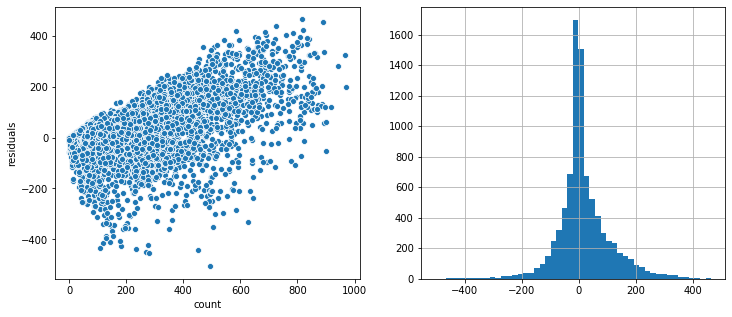

In [47]:
# check how residuals are distributed
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.scatterplot(x='count', y='residuals', data=df_train, ax=ax1)
df_train['residuals'].hist(bins=50,ax=ax2)


((array([-3.77627465, -3.5491955 , -3.42443716, ...,  3.42443716,
          3.5491955 ,  3.77627465]),
  array([-506.37326519, -454.96228381, -449.05842294, ...,  436.26199659,
          455.1991763 ,  464.10257523])),
 (89.2754932071884, 16.40851007076382, 0.9607768169068235))

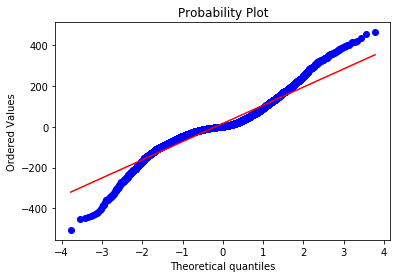

In [48]:
probplot(df_train['residuals'], plot=plt)

## 3.3 Plotting training data

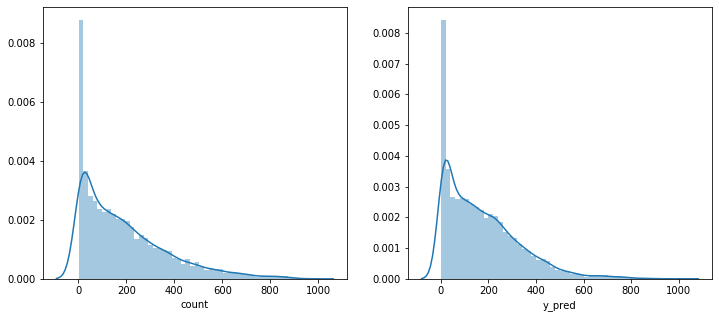

In [49]:
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(np.exp(y_train)-1,ax=ax1,bins=50)
sns.distplot(df_train['y_pred'],ax=ax2,bins=50)

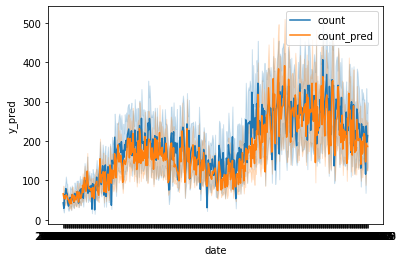

In [68]:
# plot your ypred against ytrue
# Training data
sns.lineplot(x="date", y="count", data=df_train, legend='brief', label=str('count'))
sns.lineplot(x="date", y="y_pred", data=df_train, legend='brief', label=str('count_pred'))
plt.savefig("plots/train_y_pred_y_true.png")

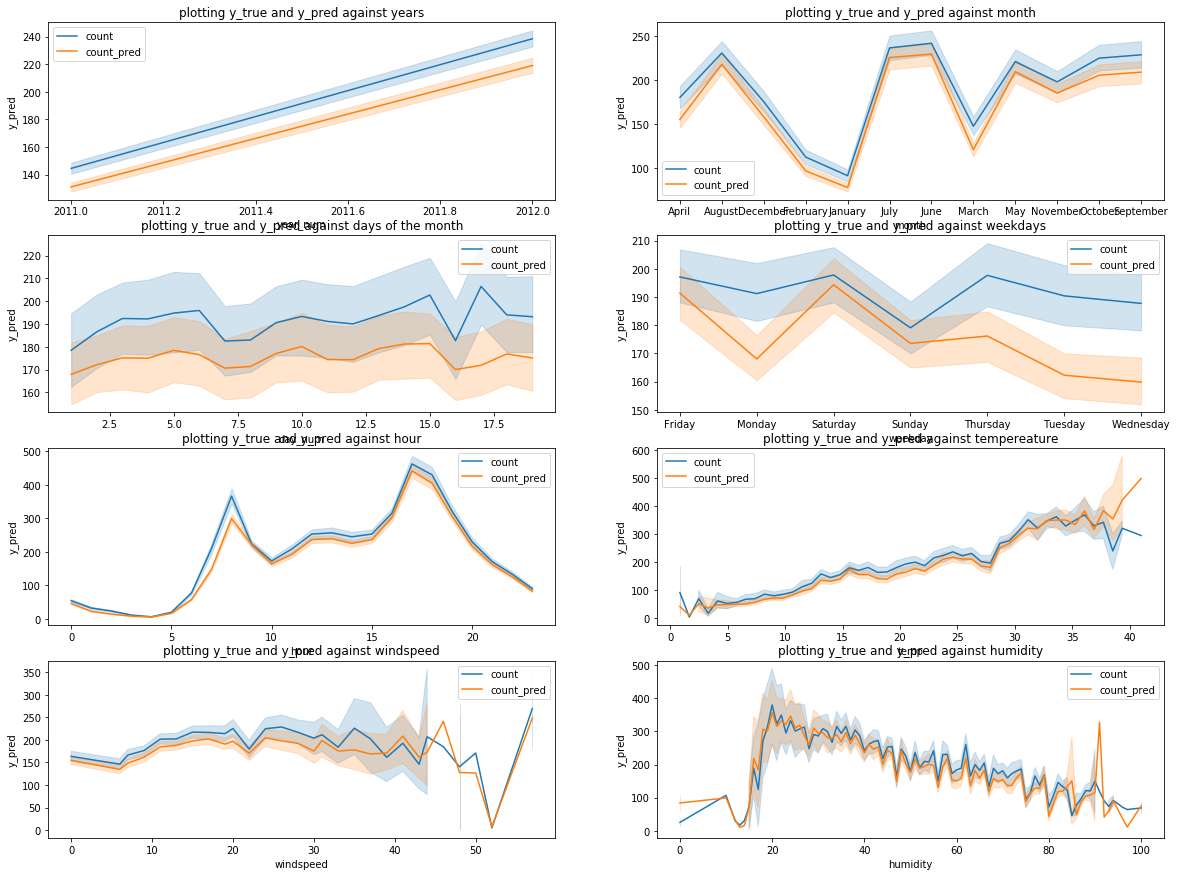

In [69]:
# plot your ypred against ytrue
# Training data
fig,((ax1,ax2), (ax3, ax4),(ax5, ax6), (ax7, ax8))= plt.subplots(ncols=2, nrows=4)
fig.set_size_inches(20,15)
sns.lineplot(x="year_num", y="count", data=df_train, ax=ax1, legend='brief', label=str('count'))
sns.lineplot(x="year_num", y="y_pred", data=df_train, ax=ax1, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against years",
                                                  label='big')
sns.lineplot(x="month", y="count", data=df_train, ax=ax2, legend='brief', label=str('count'))
sns.lineplot(x="month", y="y_pred", data=df_train, ax=ax2, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against month",
                                                  label='big')
sns.lineplot(x="day_num", y="count", data=df_train, ax=ax3, legend='brief', label=str('count'))
sns.lineplot(x="day_num", y="y_pred", data=df_train, ax=ax3, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against days of the month",
                                                  label='big')
sns.lineplot(x="weekday", y="count", data=df_train, ax=ax4, legend='brief', label=str('count'))
sns.lineplot(x="weekday", y="y_pred", data=df_train, ax=ax4, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against weekdays",
                                                  label='big')
sns.lineplot(x="hour", y="count", data=df_train, ax=ax5, legend='brief', label=str('count'))
sns.lineplot(x="hour", y="y_pred", data=df_train, ax=ax5, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against hour",
                                                  label='big')
sns.lineplot(x="temp", y="count", data=df_train, ax=ax6, legend='brief', label=str('count'))
sns.lineplot(x="temp", y="y_pred", data=df_train, ax=ax6, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against tempereature",
                                                  label='big')
sns.lineplot(x="windspeed", y="count", data=df_train, ax=ax7, legend='brief', label=str('count'))
sns.lineplot(x="windspeed", y="y_pred", data=df_train, ax=ax7, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against windspeed",
                                                  label='big')
sns.lineplot(x="humidity", y="count", data=df_train, ax=ax8, legend='brief', label=str('count'))
sns.lineplot(x="humidity", y="y_pred", data=df_train, ax=ax8, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against humidity",
                                                  label='big')
plt.savefig("plots/training_data.png")

In [52]:
#Mean squared error regression loss
print("MSE Value For Linear Regression: ",mean_squared_error(np.exp(y_train), df_train['y_pred'], squared=True).round(3))
print("Root-MSE Value For Linear Regression: ", mean_squared_error(np.exp(y_train), df_train['y_pred'], squared=False).round(3))

#MAE output is non-negative floating point. The best value is 0.0.
print("Mean absolute error For Linear Regression: ",mean_absolute_error(np.exp(y_train), df_train['y_pred']).round(3))

# R2 Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.
print("R2 For Linear Regression: ",r2_score(np.exp(y_train), df_train['y_pred']).round(3))
#MSLE, RMSLE: 
print("MSLE For Linear Regression: ",mean_squared_log_error(np.exp(y_train), df_train['y_pred']).round(3))
print("RMSLE For Linear Regression: ",np.sqrt(mean_squared_log_error(np.exp(y_train), df_train['y_pred'])).round(3))


MSE Value For Linear Regression:  8930.207
Root-MSE Value For Linear Regression:  94.5
Mean absolute error For Linear Regression:  61.429
R2 For Linear Regression:  0.727
MSLE For Linear Regression:  0.314
RMSLE For Linear Regression:  0.56


## 3.4 Plotting testing data

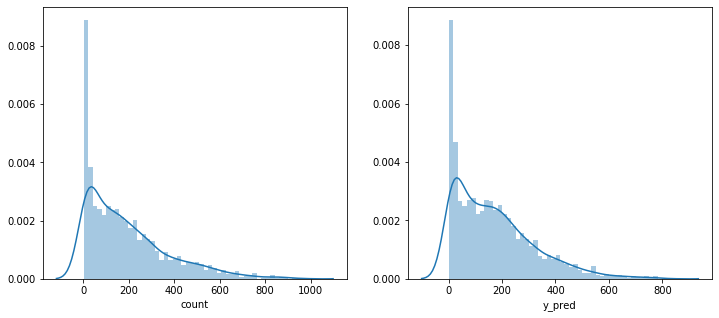

In [53]:
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(np.exp(y_test),ax=ax1,bins=50)
sns.distplot(df_test['y_pred'],ax=ax2,bins=50)

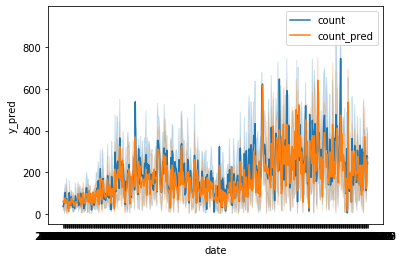

In [54]:
# plot your ypred against ytrue
# Testing data
sns.lineplot(x="date", y="count", data=df_test, legend='brief', label=str('count'))
sns.lineplot(x="date", y="y_pred", data=df_test, legend='brief', label=str('count_pred'))


[Text(0.5, 1.0, 'plotting y_true and y_pred against humidity'), None]

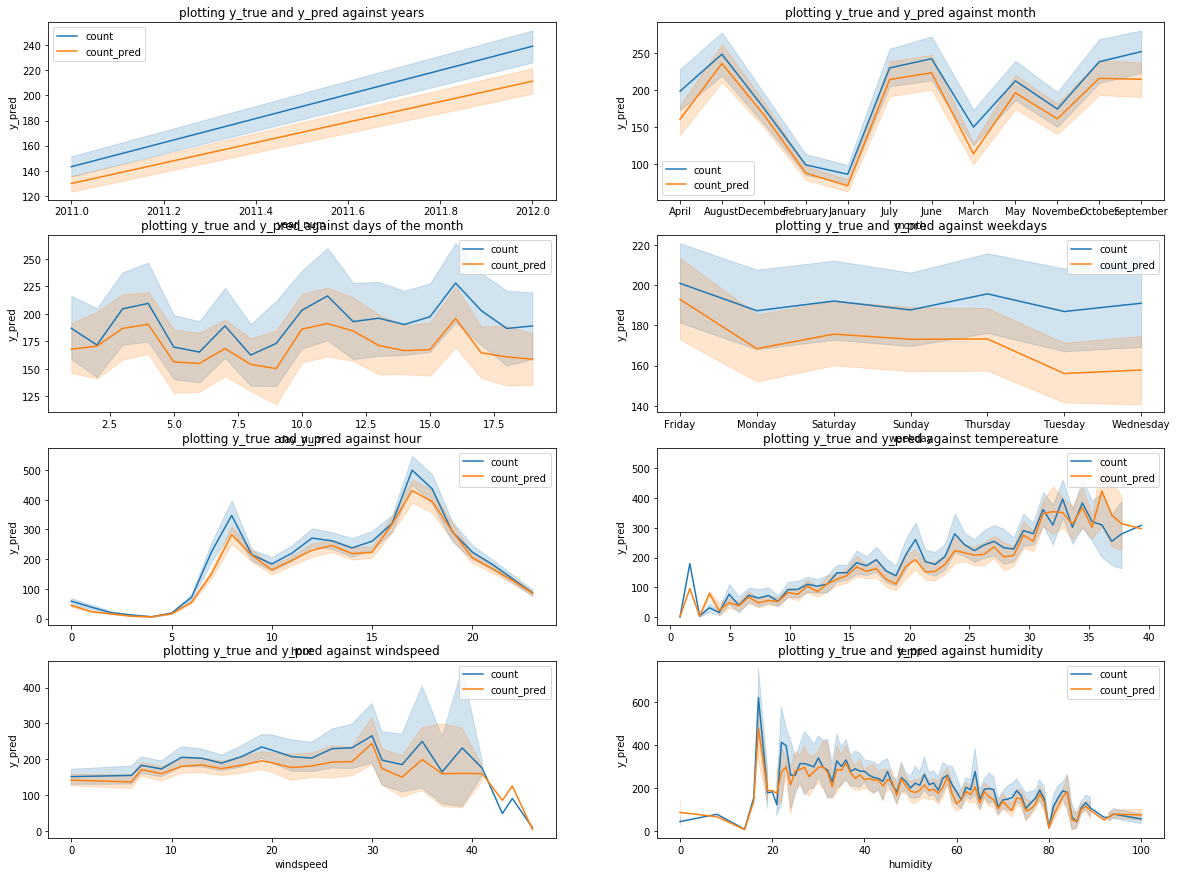

In [55]:
# plot your ypred against ytrue
# Test data
fig,((ax1,ax2), (ax3, ax4),(ax5, ax6), (ax7, ax8))= plt.subplots(ncols=2, nrows=4)
fig.set_size_inches(20,15)
sns.lineplot(x="year_num", y="count", data=df_test, ax=ax1, legend='brief', label=str('count'))
sns.lineplot(x="year_num", y="y_pred", data=df_test, ax=ax1, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against years",
                                                  label='big')
sns.lineplot(x="month", y="count", data=df_test, ax=ax2, legend='brief', label=str('count'))
sns.lineplot(x="month", y="y_pred", data=df_test, ax=ax2, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against month",
                                                  label='big')
sns.lineplot(x="day_num", y="count", data=df_test, ax=ax3, legend='brief', label=str('count'))
sns.lineplot(x="day_num", y="y_pred", data=df_test, ax=ax3, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against days of the month",
                                                  label='big')
sns.lineplot(x="weekday", y="count", data=df_test, ax=ax4, legend='brief', label=str('count'))
sns.lineplot(x="weekday", y="y_pred", data=df_test, ax=ax4, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against weekdays",
                                                  label='big')
sns.lineplot(x="hour", y="count", data=df_test, ax=ax5, legend='brief', label=str('count'))
sns.lineplot(x="hour", y="y_pred", data=df_test, ax=ax5, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against hour",
                                                  label='big')
sns.lineplot(x="temp", y="count", data=df_test, ax=ax6, legend='brief', label=str('count'))
sns.lineplot(x="temp", y="y_pred", data=df_test, ax=ax6, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against tempereature",
                                                  label='big')
sns.lineplot(x="windspeed", y="count", data=df_test, ax=ax7, legend='brief', label=str('count'))
sns.lineplot(x="windspeed", y="y_pred", data=df_test, ax=ax7, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against windspeed",
                                                  label='big')
sns.lineplot(x="humidity", y="count", data=df_test, ax=ax8, legend='brief', label=str('count'))
sns.lineplot(x="humidity", y="y_pred", data=df_test, ax=ax8, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against humidity",
                                                  label='big')

In [56]:
#Mean squared error regression loss
print("MSE Value For Linear Regression: ",mean_squared_error(np.exp(y_test), df_test['y_pred'], squared=True).round(3))
print("Root-MSE Value For Linear Regression: ", mean_squared_error(np.exp(y_test), df_test['y_pred'], squared=False).round(3))

#MAE output is non-negative floating point. The best value is 0.0.
print("Mean absolute error For Linear Regression: ",mean_absolute_error(np.exp(y_test), df_test['y_pred']).round(3))

# R2 Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.
print("R2 For Linear Regression: ",r2_score(np.exp(y_test), df_test['y_pred']).round(3))
#MSLE, RMSLE: 
print("MSLE For Linear Regression: ",mean_squared_log_error(np.exp(y_test), df_test['y_pred']).round(3))
print("RMSLE For Linear Regression: ",np.sqrt(mean_squared_log_error(np.exp(y_test), df_test['y_pred'])).round(3))


MSE Value For Linear Regression:  8965.513
Root-MSE Value For Linear Regression:  94.686
Mean absolute error For Linear Regression:  61.969
R2 For Linear Regression:  0.728
MSLE For Linear Regression:  0.313
RMSLE For Linear Regression:  0.559


## 3.5 using statsmodel looking at the features


In [57]:
# using statsmodel looking at the features
m_sm = OLS(y_train, df_train[['year__2011', 'year__2012','January','February', 'March', 'April', 'May', 'June', 
                     'July', 'August','September', 'October', 'November', 'December','Monday', 'Tuesday',
                     'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday','hour_8h', 'hour_18h', 'hour__0',
                     'hour__1', 'hour__2', 'hour__3', 'hour__4', 'hour__5', 'hour__6',
                     'hour__7', 'hour__8', 'hour__9', 'hour__10', 'hour__11', 'hour__12',
                     'hour__13', 'hour__14', 'hour__15', 'hour__16', 'hour__17', 'hour__18',
                     'hour__19', 'hour__20', 'hour__21', 'hour__22', 'hour__23','atemp_shift','season','weather','holiday','workingday', 'humidity','windspeed']])
result_sm = m_sm.fit()
result_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     930.7
Date:                Mon, 08 Jun 2020   Prob (F-statistic):               0.00
Time:                        08:57:28   Log-Likelihood:                -7622.3
No. Observations:                8708   AIC:                         1.534e+04
Df Residuals:                    8661   BIC:                         1.567e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
year__2011      1.9480      0.015    131.553      0.000       1.919       1.977
year__2012      2.4264      0.014    179.468      0.000       2.400       2.453
January         1.1706      0.027     42.792      0.000       1.117       1.224
February        1.3207      0.025     53.825      0.000       1.273       1.369
March           1.3800      0.022     64.074      0.000       1.338       1.422
April           0.7168      0.021     33.857      0.000       0.675       0.758
May             0.9271      0.022     42.728      0.000       0.885       0.970
June            0.8751      0.023     37.513      0.000       0.829       0.921
July           -0.0284      0.024     -1.164      0.244      -0.076       0.019
August         -0.0008      0.024     -0.035      0.972      -0.048       0.046
September       0.0352      0.022      1.563      0.118      -0.009       0.079
October        -0.6657      0.019    -34.756      0.000      -0.703      -0.628
November       -0.6671      0.022    -30.452      0.000      -0.710      -0.624
December       -0.6890      0.023    -30.120      0.000      -0.734      -0.644
Monday          0.3246      0.015     21.321      0.000       0.295       0.354
Tuesday         0.3110      0.016     19.389      0.000       0.280       0.342
Wednesday       0.3054      0.016     19.260      0.000       0.274       0.336
Thursday        0.3689      0.016     23.291      0.000       0.338       0.400
Friday          0.4749      0.016     30.419      0.000       0.444       0.506
Saturday        1.3464      0.016     82.636      0.000       1.314       1.378
Sunday          1.2432      0.016     75.577      0.000       1.211       1.275
hour_8h         0.0336      0.002     21.301      0.000       0.031       0.037
hour_18h       -0.1096      0.002    -69.923      0.000      -0.113      -0.107
hour__0         0.4491      0.027     16.390      0.000       0.395       0.503
hour__1        -0.2733      0.028     -9.686      0.000      -0.329      -0.218
hour__2        -0.7704      0.028    -27.069      0.000      -0.826      -0.715
hour__3        -1.3723      0.029    -46.663      0.000      -1.430      -1.315
hour__4        -1.7003      0.029    -57.720      0.000      -1.758      -1.643
hour__5        -0.8266      0.029    -28.296      0.000      -0.884      -0.769
hour__6         0.2975      0.030     10.007      0.000       0.239       0.356
hour__7         1.1542      0.030     38.733      0.000       1.096       1.213
hour__8         1.7319      0.029     60.307      0.000       1.676       1.788
hour__9         1.2538      0.029     42.578      0.000       1.196       1.312
hour__10        0.7822      0.029     26.786      0.000       0.725       0.839
hour__11        0.7580      0.030     25.682      0.000       0.700       0.816
hour__12        0.7889      0.029     26.78

## 4. Save submission file for kaggle

In [ ]:
submission = pd.DataFrame({'datetime': bike_test.datetime, 'count': bike_test.y_pred},
                          columns=['datetime', 'count'])
submission.to_csv("submission.csv", index=False)